# Dilated Convolution with Learnable Spacings

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import torch
import torch.nn as nn

from tqdm.auto import tqdm as pbar

dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

from typing import Optional, Tuple
import math

## Hyperparameters

In [ ]:
# Constants
SECONDS = 1
MS = 1e-3
HZ = 1

DT = 1 * MS            # large time step to make simulations run faster
ANF_PER_EAR = 100    # repeats of each ear with independent noise

DURATION = .1 * SECONDS # stimulus duration
DURATION_STEPS = int(np.round(DURATION / DT))
INPUT_SIZE = 2 * ANF_PER_EAR

# Training
LR = 0.001
N_EPOCHS = 150
batch_size = 64
n_training_batches = 64
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# classes at 15 degree increments
NUM_CLASSES = 180 // 15
print(f'Number of classes = {NUM_CLASSES}')

# Network
NUM_HIDDEN = 30 # number of hidden units
TAU = 5 # membrane time constant

max_delay = 300//10
max_delay = max_delay if max_delay%2==1 else max_delay+1 # to make kernel_size an odd number
left_padding = max_delay-1
right_padding = (max_delay-1) // 2

Number of classes = 12


## Functions

### Stimulus

In [ ]:
def input_signal(ipd, poisson, with_delays = False):
    """
    Generate an input signal (spike array) from array of true IPDs
    """
    envelope_power = 2   # higher values make sharper envelopes, easier
    rate_max = 600 * HZ   # maximum Poisson firing rate
    stimulus_frequency = 20 * HZ

    num_samples = len(ipd)
    times = np.arange(DURATION_STEPS) * DT # array of times
    phi = 2*np.pi*(stimulus_frequency * times + np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    if with_delays:
      # for each ear, we have anf_per_ear different phase delays from to pi/2 so
      # that the differences between the two ears can cover the full range from -pi/2 to pi/2
      phase_delays = np.linspace(0, np.pi/2, ANF_PER_EAR)
    else:
      phase_delays = np.zeros((ANF_PER_EAR))
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    if poisson is None:
      poisson = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)
    spikes = poisson<rate_max*DT*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

def random_ipd_input_signal(num_samples, tensor=True):
    """
    Generate the training data
    Returns true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    poisson = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)

    return ipd, poisson

def spikes_from_fixed_idp_input_signal(ipd, poisson=None, tensor=True, with_delays=False):
    spikes = input_signal(ipd, poisson, with_delays)
    if tensor:
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return spikes

def show_examples(shown=8):
    ipd = np.linspace(-np.pi/2, np.pi/2, shown)
    spikes = spikes_from_fixed_idp_input_signal(ipd, shown).cpu()

    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(shown):
        plt.subplot(2, shown // 2, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
    plt.tight_layout()

def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

def discretise(ipds):
    return ((ipds+np.pi/2) * NUM_CLASSES / np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5) / NUM_CLASSES * np.pi - np.pi / 2

Without delays

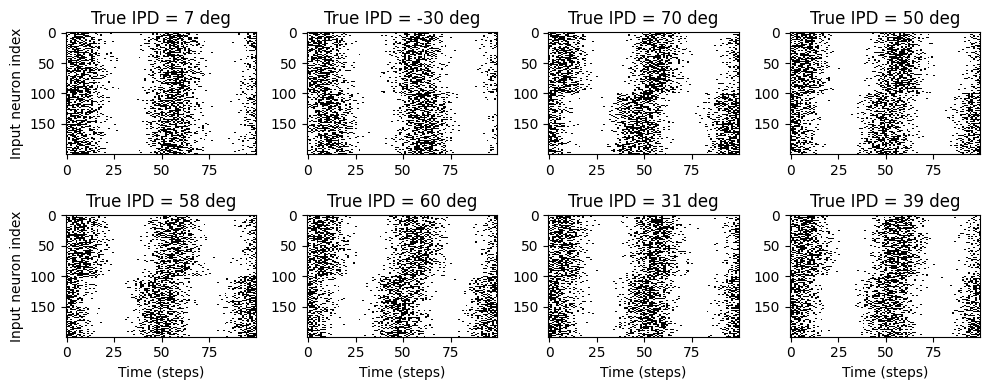

In [ ]:
# Plot a few just to show how it looks
ipds, poisson = random_ipd_input_signal(8, False)
spikes = spikes_from_fixed_idp_input_signal(ipds, poisson, True, False)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipds[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

With delays

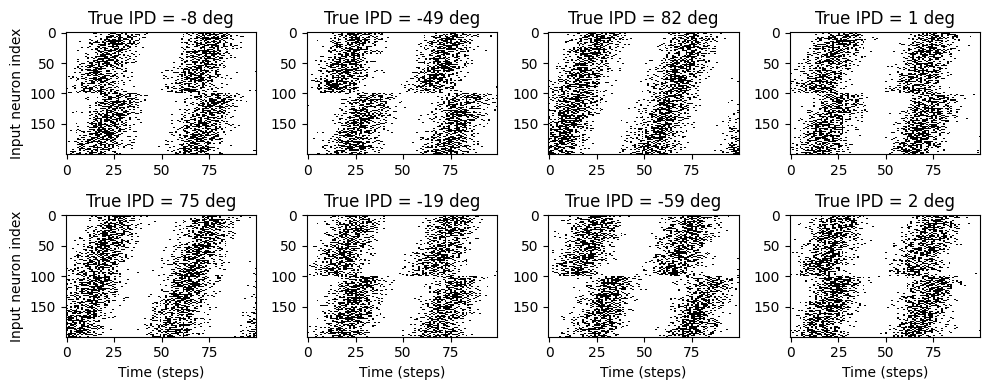

In [ ]:
# Plot a few just to show how it looks
ipds, poisson = random_ipd_input_signal(8, False)
spikes = spikes_from_fixed_idp_input_signal(ipds, poisson, True, True)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipds[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

### SNN

In [ ]:
def sigmoid(x, beta):
    return 1 / (1 + torch.exp(-beta*x))

def sigmoid_deriv(x, beta):
    s = sigmoid(x, beta)
    return beta * s * (1 - s)

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        ctx.save_for_backward(inp)
        out = torch.zeros_like(inp)
        out[inp > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        inp, = ctx.saved_tensors
        sigmoid_derivative = sigmoid_deriv(inp, beta=5)
        grad = grad_output*sigmoid_derivative
        return grad

spike_fn  = SurrGradSpike.apply

def membrane_only(input_spikes, tau):
    """
    :param input_spikes: has shape (batch_size, duration_steps, input_size)
    :param weights: has shape  (input_size, num_classes
    :param tau:
    :return:
    """
    batch_size = input_spikes.shape[0]
    assert len(input_spikes.shape) == 3

    v = torch.zeros((batch_size, NUM_CLASSES), device=device, dtype=dtype)
    v_rec = [v]
    h = input_spikes
    alpha = np.exp(-DT / tau)
    for t in range(DURATION_STEPS - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

def layer1(input_spikes, tau):


    batch_size = input_spikes.shape[0]

    # First layer: input to hidden
    v = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]
    h = input_spikes
    alpha = np.exp(-DT / tau)

    for t in range(DURATION_STEPS - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    return s_rec

def layer2(s_rec, tau):
    """Second layer: hidden to output"""

    v_rec = membrane_only(s_rec, tau=tau)
    return v_rec

def snn(input_spikes, w1, w2, tau=5*MS):
    """Run the simulation"""
    x = input_spikes.permute(0,2,1)
    x = nn.functional.pad(x, (left_padding, right_padding), 'constant', 0)
    x = w1(x)
    x = x.permute(0,2,1)
    s_rec = layer1(x, tau)
    x = s_rec.permute(0,2,1)
    x = nn.functional.pad(x, (left_padding, right_padding), 'constant', 0)
    x = w2(x)
    x = x.permute(0,2,1)
    v_rec = layer2(x, tau)
    # Return recorded membrane potential of output
    return v_rec

Code from https://github.com/K-H-Ismail/Dilated-Convolution-with-Learnable-Spacings-PyTorch

In [ ]:
class _DclsNd(nn.modules.Module):

    __constants__ = ['stride', 'padding', 'dilated_kernel_size', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_count', 'version']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def _conv_forward(self, input: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor]) -> torch.Tensor:
        ...

    _in_channels: int
    out_channels: int
    kernel_count: int
    stride: Tuple[int, ...]
    padding: Tuple[int, ...]
    dilated_kernel_size: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: torch.Tensor
    bias: Optional[torch.Tensor]

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_count: int,
                 stride: Tuple[int, ...],
                 padding: Tuple[int, ...],
                 dilated_kernel_size: Tuple[int, ...],
                 transposed: bool,
                 output_padding: Tuple[int, ...],
                 groups: int,
                 bias: bool,
                 padding_mode: str,
                 version: str) -> None:
        super(_DclsNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_count = kernel_count
        self.stride = stride
        self.padding = padding
        self.dilated_kernel_size = dilated_kernel_size
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        self.version = version
        # `_reversed_padding_repeated_twice` is the padding to be passed to
        # `F.pad` if needed (e.g., for non-zero padding types that are
        # implemented as two ops: padding + conv). `F.pad` accepts paddings in
        # reverse order than the dimension.
        self._reversed_padding_repeated_twice = nn.modules.utils._reverse_repeat_tuple(self.padding, 2)
        if transposed:
            self.weight = nn.parameter.Parameter(torch.Tensor(
                in_channels, out_channels // groups, kernel_count))
            self.P = nn.parameter.Parameter(torch.Tensor(len(dilated_kernel_size), in_channels,
                                            out_channels // groups, kernel_count))
            if version in ['gauss', 'max']:
                self.SIG = nn.parameter.Parameter(torch.Tensor(len(dilated_kernel_size), in_channels,
                                                out_channels // groups, kernel_count))
            else:
                self.register_parameter('SIG', None)
        else:
            self.weight = nn.parameter.Parameter(torch.Tensor(
                out_channels, in_channels // groups, kernel_count))
            self.P = nn.parameter.Parameter(torch.Tensor(len(dilated_kernel_size),
                                            out_channels, in_channels // groups, kernel_count))
            if version in ['gauss', 'max']:
                self.SIG = nn.parameter.Parameter(torch.Tensor(len(dilated_kernel_size), out_channels,
                    in_channels // groups, kernel_count))
            else:
                self.register_parameter('SIG', None)
        if bias:
            self.bias = nn.parameter.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        with torch.no_grad():
            for i in range(len(self.dilated_kernel_size)):
                lim = self.dilated_kernel_size[i] // 2
                nn.init.normal_(self.P.select(0,i), 0, 0.5).clamp(-lim, lim)
            if self.SIG is not None:
                if self.version == 'gauss':
                    nn.init.constant_(self.SIG, 0.23)
                else:
                    nn.init.constant_(self.SIG, 0.0)

    def clamp_parameters(self) -> None:
        for i in range(len(self.dilated_kernel_size)):
            with torch.no_grad():
                lim = self.dilated_kernel_size[i] // 2
                self.P.select(0,i).clamp_(-lim, lim)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_count={kernel_count} (previous kernel_size)'
             ', stride={stride}, version={version}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilated_kernel_size != (1,) * len(self.dilated_kernel_size):
            s += ', dilated_kernel_size={dilated_kernel_size} (learnable)'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_DclsNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

In [ ]:
class ConstructKernel1d(nn.modules.Module):
    def __init__(self, out_channels, in_channels, groups, kernel_count, dilated_kernel_size, version):
        super().__init__()
        self.version = version
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.groups = groups
        self.dilated_kernel_size = dilated_kernel_size
        self.kernel_count = kernel_count
        self.IDX = None
        self.lim = None

    def __init_tmp_variables__(self, device):
        if self.IDX is None or self.lim is None:
            I = nn.parameter.Parameter(torch.arange(0, self.dilated_kernel_size[0]), requires_grad=False).to(device)
            IDX = I.unsqueeze(0)
            IDX = IDX.expand(self.out_channels, self.in_channels//self.groups, self.kernel_count, -1, -1).permute(4,3,0,1,2)
            self.IDX = IDX
            lim = torch.tensor(self.dilated_kernel_size).to(device)
            self.lim = lim.expand(self.out_channels, self.in_channels//self.groups, self.kernel_count, -1).permute(3,0,1,2)
        else:
            pass

    def forward_vmax(self, W, P, SIG):
        P = P + self.lim // 2
        SIG = SIG.abs() + 1.0
        X = (self.IDX - P)
        X = ((SIG - X.abs()).relu()).prod(1)
        X  = X / (X.sum(0) + 1e-7) # normalization
        K = (X * W).sum(-1)
        K = K.permute(1,2,0)
        return K

    def forward_vgauss(self, W, P, SIG):
        P = P + self.lim // 2
        SIG = SIG.abs() + 0.27
        X = ((self.IDX - P) / SIG).norm(2, dim=1)
        X = (-0.5 * X**2).exp()
        X  = X / (X.sum(0) + 1e-7) # normalization
        K = (X * W).sum(-1)
        K = K.permute(1,2,0)
        return K

    def forward(self, W, P, SIG):
        self.__init_tmp_variables__(W.device)
        if self.version == 'max':
            return self.forward_vmax(W, torch.clamp(torch.round(P), -(self.dilated_kernel_size[0] // 2), (self.dilated_kernel_size[0]// 2)), torch.zeros_like(SIG))
        elif self.version == 'gauss':
            return self.forward_vgauss(W, P, SIG)
        else:
            raise

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_count={kernel_count}, version={version}')
        if self.dilated_kernel_size != (1,) * len(self.dilated_kernel_size):
            s += ', dilated_kernel_size={dilated_kernel_size}'
        if self.groups != 1:
            s += ', groups={groups}'
        return s.format(**self.__dict__)

In [ ]:
class Dcls1d(_DclsNd):
    __doc__ = r"""

    Shape:
        - Input: :math:`(N, C_{in}, L_{in})` or :math:`(C_{in}, L_{in})`
        - Output: :math:`(N, C_{out}, L_{out})` or :math:`(C_{out}, L_{out})`, where

          .. math::
              L_{out} = \left\lfloor\frac{L_{in} + 2 \times \text{padding} - \text{dilation}
                        \times (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1\right\rfloor

    Attributes:
        weight (Tensor): the learnable weights of the module of shape
            :math:`(\text{out\_channels},
            \frac{\text{in\_channels}}{\text{groups}}, \text{kernel\_size})`.
            The values of these weights are sampled from
            :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
            :math:`k = \frac{groups}{C_\text{in} * \text{kernel\_size}}`
        bias (Tensor):   the learnable bias of the module of shape
            (out_channels). If :attr:`bias` is ``True``, then the values of these weights are
            sampled from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
            :math:`k = \frac{groups}{C_\text{in} * \text{kernel\_size}}`

    Examples::

        >>> m = nn.Conv1d(16, 33, 3, stride=2)
        >>> input = torch.randn(20, 16, 50)
        >>> output = m(input)

    .. _cross-correlation:
        https://en.wikipedia.org/wiki/Cross-correlation

    .. _link:
        https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_count: int,
        stride: nn.common_types._size_1_t = 1,
        padding: nn.common_types._size_1_t = 0,
        dilated_kernel_size: nn.common_types._size_1_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        version: str = 'v1'
    ):
        stride_ = nn.modules.utils._single(stride)
        padding_ = nn.modules.utils._single(padding)
        dilated_kernel_size_ = nn.modules.utils._single(dilated_kernel_size)
        super(Dcls1d, self).__init__(
            in_channels, out_channels, kernel_count, stride_, padding_, dilated_kernel_size_,
            False, nn.modules.utils._single(0), groups, bias, padding_mode, version)

        self.DCK = ConstructKernel1d(self.out_channels,
                                     self.in_channels,
                                     self.groups,
                                     self.kernel_count,
                                     self.dilated_kernel_size,
                                     self.version)
    def extra_repr(self):
        s = super(Dcls1d, self).extra_repr()
        return s.format(**self.__dict__)

    def _conv_forward(self, input: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor], P: torch.Tensor, SIG: Optional[torch.Tensor]):
            if self.padding_mode != 'zeros':
                return nn.functional.conv1d(nn.functional.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                                self.DCK(weight, P, SIG), bias,
                                self.stride, nn.modules.utils._single(0), nn.modules.utils._single(1), self.groups)
            return nn.functional.conv1d(input, self.DCK(weight, P, SIG), bias,
                                   self.stride, self.padding, nn.modules.utils._single(1), self.groups)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
            return self._conv_forward(input, self.weight, self.bias, self.P, self.SIG)

In [ ]:
def init_weight_matrices():
    """Weights initialisation"""

    w1 = Dcls1d(INPUT_SIZE, NUM_HIDDEN, kernel_count=1, groups = 1, dilated_kernel_size = max_delay, bias=False, version='gauss')
    w2 = Dcls1d(NUM_HIDDEN, NUM_CLASSES, kernel_count=1, groups = 1, dilated_kernel_size = max_delay, bias=False, version='gauss')

    nn.init.kaiming_uniform_(w1.weight, nonlinearity='relu')
    nn.init.kaiming_uniform_(w2.weight, nonlinearity='relu')

    torch.nn.init.constant_(w1.SIG, max_delay // 2 )
    w1.SIG.requires_grad = False
    torch.nn.init.constant_(w2.SIG, max_delay // 2 )
    w2.SIG.requires_grad = False

    return w1, w2

### Training

In [ ]:
def train(w1, w2, ipds, poisson, ipds_validation, poisson_validation, lr=0.001, n_epochs=150, tau=5*MS):
    """
    :param lr: learning rate
    :return:
    """
    # Optimiser and loss function
    positions = []
    weights = []
    positions.append(w1.P)
    weights.append(w1.weight)
    positions.append(w2.P)
    weights.append(w2.weight)

    optimizers = []
    optimizers.append(torch.optim.Adam([{'params':weights, 'lr':lr}]))
    optimizers.append(torch.optim.Adam(positions, lr = lr * 100))

    schedulers = []
    schedulers.append(torch.optim.lr_scheduler.OneCycleLR(optimizers[0], max_lr=5*lr, total_steps=n_epochs))
    schedulers.append(torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[1], T_max=n_epochs))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    val_loss_hist = []

    best_loss = 1e10
    val_loss_best_loss = 1e10

    for e in pbar(range(n_epochs)):
        local_loss = []
        spikes = spikes_from_fixed_idp_input_signal(ipds, poisson)
        for x_local, y_local in data_generator(discretise(torch.tensor(ipds, device=device, dtype=dtype)), spikes):
            # Run network
            output = snn(x_local, w1, w2, tau=tau)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            reg = 0
            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            for opt in optimizers: opt.zero_grad()
            loss.backward()
            for opt in optimizers: opt.step()

            w1.clamp_parameters()
            w2.clamp_parameters()

        loss_hist.append(np.mean(local_loss))

        for scheduler in schedulers: scheduler.step()

        alpha = 0
        sig = w2.SIG[0,0,0,0].detach().cpu().item()
        if e < ((1*n_epochs)//4)  and sig > 0.23:
          alpha = (0.23/(max_delay // 2  ))**(1/(((1*n_epochs)//4)))
          w1.SIG *= alpha
          w2.SIG *= alpha

        val_local_loss = []


        with torch.no_grad():

          w1.version = 'max'
          w1.DCK.version = 'max'
          w2.version = 'max'
          w2.DCK.version = 'max'
          w1.clamp_parameters()
          w2.clamp_parameters()
          spikes_validation = spikes_from_fixed_idp_input_signal(ipds_validation, poisson_validation)
          for x_local, y_local in data_generator(discretise(torch.tensor(ipds_validation, device=device, dtype=dtype)), spikes_validation):
              # Run network
              output = snn(x_local, w1, w2, tau=tau)
              # Compute cross entropy loss
              m = torch.sum(output, 1)*0.01  # Sum time dimension

              val_loss = loss_fn(log_softmax_fn(m), y_local)
              val_local_loss.append(val_loss.item())

              w1.clamp_parameters()
              w2.clamp_parameters()

        w1.version = 'gauss'
        w1.DCK.version = 'gauss'
        w2.version = 'gauss'
        w2.DCK.version = 'gauss'

        val_loss_hist.append(np.mean(val_local_loss))

        if np.mean(val_local_loss) < val_loss_best_loss:
            val_loss_best_loss = np.mean(val_local_loss)
            best_weights = w1, w2

        #Early Stopping :
        if torch.tensor(val_loss_hist[-10:]).argmin() == 0  and e>10:
            print('Early Stop !')
            return best_weights

    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.plot(val_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    return w1, w2

### Testing

In [ ]:
def test_accuracy(ipds, poisson, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    spikes = spikes_from_fixed_idp_input_signal(ipds, poisson)
    for x_local, y_local in data_generator((torch.tensor(ipds, device=device, dtype=dtype)), spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):

    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / np.pi, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / np.pi, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()

def analyse_accuracy(ipds, poisson, run, label):
    ipd_true, ipd_est, confusion, accs = test_accuracy(ipds, poisson, run)
    report_accuracy(ipd_true, ipd_est, confusion, accs, label)
    return 100*np.mean(accs)

## Train Network

In [ ]:
# Generate the training data
w1, w2 = init_weight_matrices()

ipds_training, poisson_training = random_ipd_input_signal(num_samples, False)
ipds_validation, poisson_validation = random_ipd_input_signal(num_samples, False)

# Train network
w1_trained, w2_trained = train(w1=w1, w2=w2,  ipds=ipds_training, poisson=poisson_training, poisson_validation=poisson_validation, ipds_validation=ipds_validation, lr=LR, n_epochs=N_EPOCHS, tau=TAU*MS)

  0%|          | 0/150 [00:00<?, ?it/s]

Early Stop !


Chance accuracy level: 8.3%

Train classifier accuracy: 89.9%
Train absolute error: 4.1 deg

Test classifier accuracy: 88.2%
Test absolute error: 4.2 deg


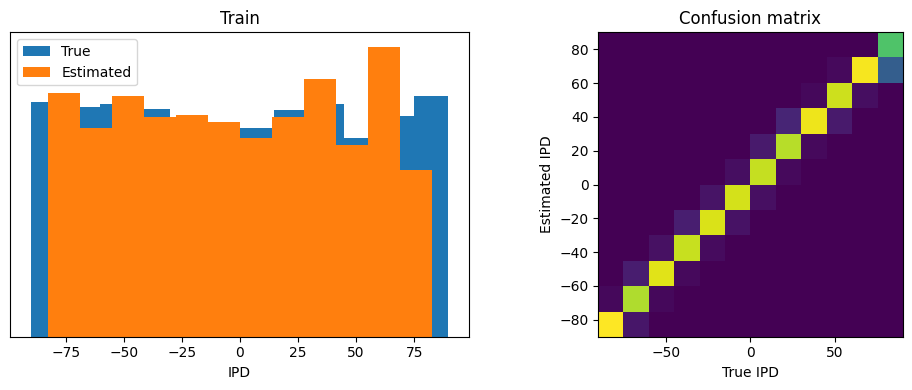

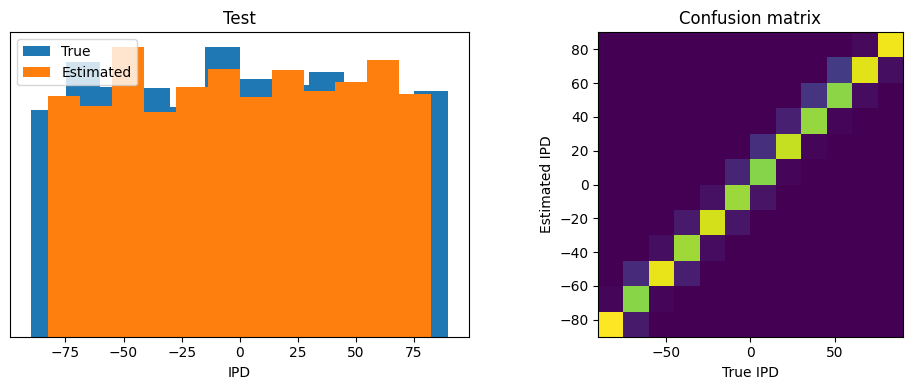

In [ ]:
with torch.no_grad():
  w1_trained.version = 'max'
  w1_trained.DCK.version = 'max'
  w2_trained.version = 'max'
  w2_trained.DCK.version = 'max'
  # Analyse
  print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
  run_func = lambda x: snn(x, w1_trained, w2_trained)
  analyse_accuracy(ipds_training, poisson_training, run_func, 'Train')

  ipds_test, poisson_test = random_ipd_input_signal(batch_size*n_testing_batches, False)
  analyse_accuracy(ipds_test, poisson_test, run_func, 'Test')

In [ ]:
w1_delay = w1_trained.P.squeeze().detach().round_()

In [ ]:
print("Minimum: ", torch.min(w1_delay), "Maximum: ", torch.max(w1_delay), "Mean: ", torch.mean(w1_delay), "STD: ", torch.std(w1_delay))

Minimum:  tensor(-15.) Maximum:  tensor(15.) Mean:  tensor(6.5355) STD:  tensor(7.2640)


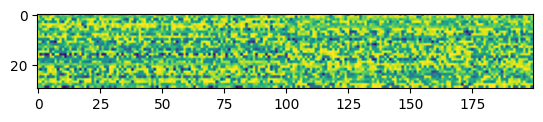

In [ ]:
plt.imshow(w1_delay.numpy())

In [ ]:
w2_delay = w2_trained.P.squeeze().detach().round_()

In [ ]:
print("Minimum: ", torch.min(w2_delay), "Maximum: ", torch.max(w2_delay), "Mean: ", torch.mean(w2_delay), "STD: ", torch.std(w2_delay))

Minimum:  tensor(-15.) Maximum:  tensor(15.) Mean:  tensor(4.8556) STD:  tensor(10.8649)


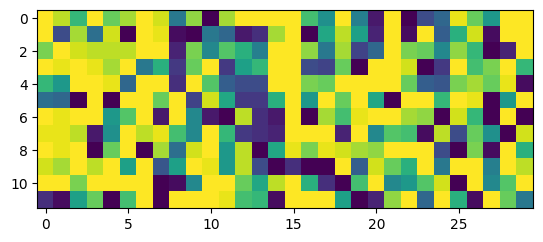

In [ ]:
plt.imshow(w2_delay.numpy())

Now go from 30ms max delay to 25ms

In [ ]:
max_delay = 250//10
max_delay = max_delay if max_delay%2==1 else max_delay+1 # to make kernel_size an odd number
left_padding = max_delay-1
right_padding = (max_delay-1) // 2

In [ ]:
# Generate the training data
w1, w2 = init_weight_matrices()

# Train network
w1_trained, w2_trained = train(w1=w1, w2=w2,  ipds=ipds_training, poisson=poisson_training, poisson_validation=poisson_validation, ipds_validation=ipds_validation, lr=LR, n_epochs=N_EPOCHS, tau=TAU*MS)

  0%|          | 0/150 [00:00<?, ?it/s]

Early Stop !


Chance accuracy level: 8.3%

Train classifier accuracy: 80.3%
Train absolute error: 4.8 deg

Test classifier accuracy: 81.8%
Test absolute error: 4.6 deg


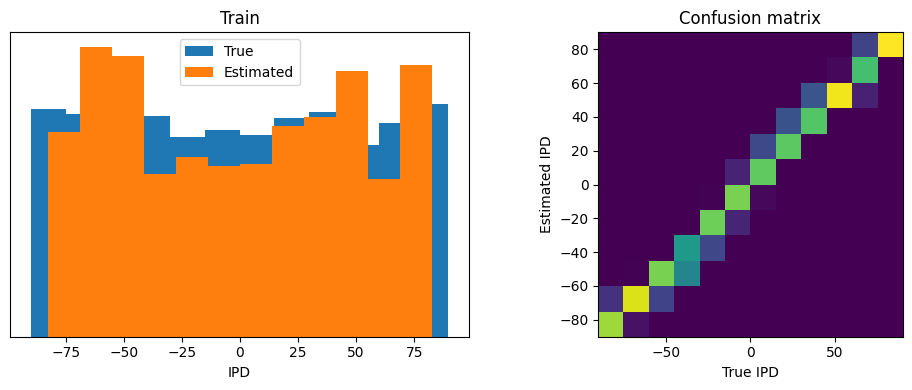

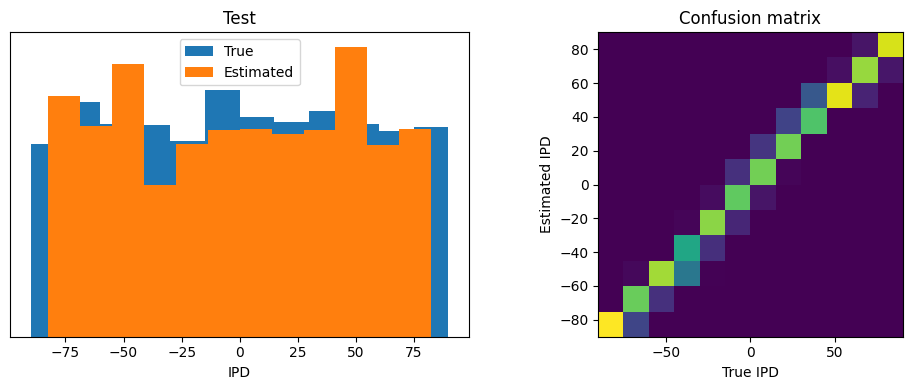

In [ ]:
with torch.no_grad():
  w1_trained.version = 'max'
  w1_trained.DCK.version = 'max'
  w2_trained.version = 'max'
  w2_trained.DCK.version = 'max'
  # Analyse
  print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
  run_func = lambda x: snn(x, w1_trained, w2_trained)
  analyse_accuracy(ipds_training, poisson_training, run_func, 'Train')

  analyse_accuracy(ipds_test, poisson_test, run_func, 'Test')

In [ ]:
w1_delay = w1_trained.P.squeeze().detach().round_()

In [ ]:
print("Minimum: ", torch.min(w1_delay), "Maximum: ", torch.max(w1_delay), "Mean: ", torch.mean(w1_delay), "STD: ", torch.std(w1_delay))

Minimum:  tensor(-12.) Maximum:  tensor(12.) Mean:  tensor(3.8682) STD:  tensor(6.5771)


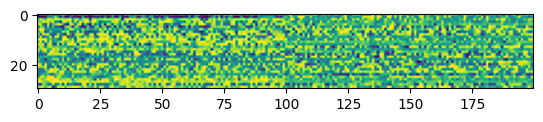

In [ ]:
plt.imshow(w1_delay.numpy())

In [ ]:
w2_delay = w2_trained.P.squeeze().detach().round_()

In [ ]:
print("Minimum: ", torch.min(w2_delay), "Maximum: ", torch.max(w2_delay), "Mean: ", torch.mean(w2_delay), "STD: ", torch.std(w2_delay))

Minimum:  tensor(-12.) Maximum:  tensor(12.) Mean:  tensor(4.1833) STD:  tensor(8.6819)


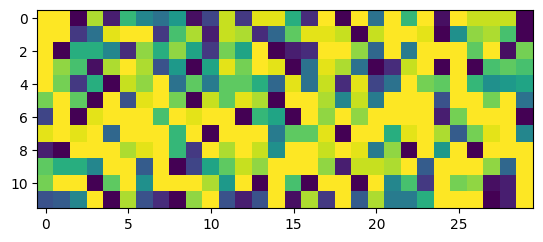

In [ ]:
plt.imshow(w2_delay.numpy())

Train accuracy is slightly lower than test..Seems like 25 is too small , let's see 35

In [ ]:
max_delay = 350//10
max_delay = max_delay if max_delay%2==1 else max_delay+1 # to make kernel_size an odd number
left_padding = max_delay-1
right_padding = (max_delay-1) // 2

In [ ]:
# Generate the training data
w1, w2 = init_weight_matrices()

# Train network
w1_trained, w2_trained = train(w1=w1, w2=w2,  ipds=ipds_training, poisson=poisson_training, poisson_validation=poisson_validation, ipds_validation=ipds_validation, lr=LR, n_epochs=N_EPOCHS, tau=TAU*MS)

  0%|          | 0/150 [00:00<?, ?it/s]

Early Stop !


Chance accuracy level: 8.3%

Train classifier accuracy: 85.1%
Train absolute error: 4.4 deg

Test classifier accuracy: 84.4%
Test absolute error: 4.4 deg


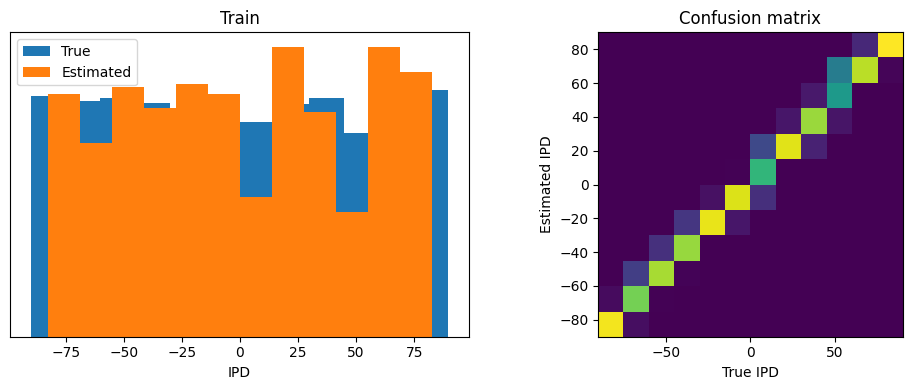

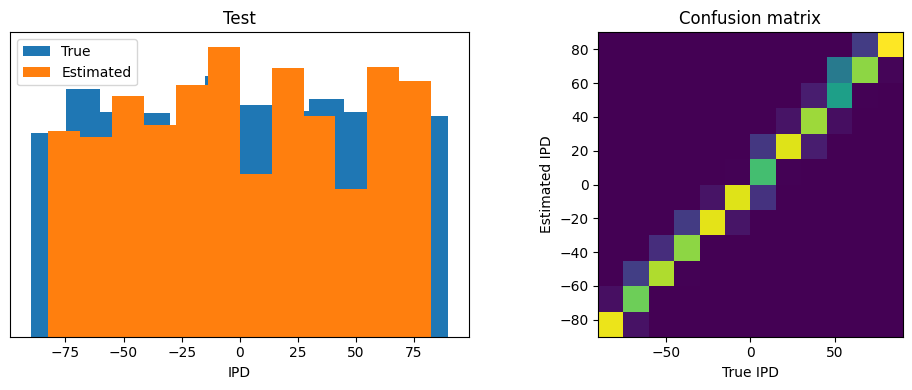

In [ ]:
with torch.no_grad():
  w1_trained.version = 'max'
  w1_trained.DCK.version = 'max'
  w2_trained.version = 'max'
  w2_trained.DCK.version = 'max'
  # Analyse
  print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
  run_func = lambda x: snn(x, w1_trained, w2_trained)
  analyse_accuracy(ipds_training, poisson_training, run_func, 'Train')

  analyse_accuracy(ipds_test, poisson_test, run_func, 'Test')

In [ ]:
w1_delay = w1_trained.P.squeeze().detach().round_()

In [ ]:
print("Minimum: ", torch.min(w1_delay), "Maximum: ", torch.max(w1_delay), "Mean: ", torch.mean(w1_delay), "STD: ", torch.std(w1_delay))

Minimum:  tensor(-17.) Maximum:  tensor(17.) Mean:  tensor(5.5645) STD:  tensor(9.3541)


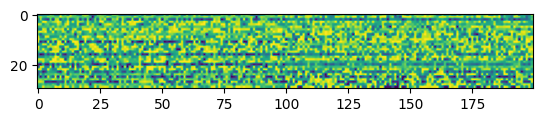

In [ ]:
plt.imshow(w1_delay.numpy())

In [ ]:
w2_delay = w2_trained.P.squeeze().detach().round_()

In [ ]:
print("Minimum: ", torch.min(w2_delay), "Maximum: ", torch.max(w2_delay), "Mean: ", torch.mean(w2_delay), "STD: ", torch.std(w2_delay))

Minimum:  tensor(-17.) Maximum:  tensor(17.) Mean:  tensor(6.9472) STD:  tensor(12.1914)


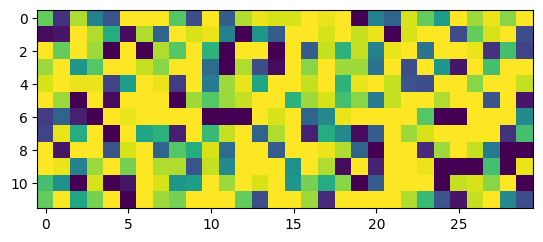

In [ ]:
plt.imshow(w2_delay.numpy())

35 seems like too much